### Introduction
Goal here is to use an XGBoost classifier to predict wildfire ignition from weather variables. Three anticipated issues are:

1. Large dataset size - current working dataset has 7.3 million observations of 25 variables and this is likely to grow as the project progresses
2. Highly imbalanced data (~20 times more observations without fire than with)
3. Overlapping classes - just because the right conditions for ignition exist does not guarantee a fire.

We can hopefully deal with 1 and 2 fairly easily. The third is a deeper question/problem that will need some additional thought and likely a switch from binary classification to ignition probabilities and regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from time import time
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from xgboost import XGBClassifier
from IPython.display import display_markdown
from scipy.interpolate import griddata

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

%matplotlib inline
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()

<Figure size 432x288 with 0 Axes>

**Variable definitions**

In [2]:
data_file = '../training_data_pipeline/data/stratified_training_data/1992-2015_california_features_added_n500000_ks_pval0.3.1.parquet'
rand_seed = 123
#data_sample_fraction = 0.001
test_train_split_ratio = 0.3
xgb_jobs = 5
optimization_jobs = 3
search_iterations = 5
search_scoring_func = make_scorer(average_precision_score)

**Functions**

In [3]:
def random_sample(data, fraction):
    n = len(data)
    k = int(len(data) * fraction)
    
    indices = random.sample(range(0, n), k)
    
    return data.iloc[indices]

def print_model_score(model, x_train, y_train, x_test, y_test):
    training_score = average_precision_score(model.predict(x_train), y_train)
    test_score = average_precision_score(model.predict(x_test), y_test)
    
    #print('Average precision-recall score, training set: {}'.format(np.round(training_score, 2)))
    #print('<b>Average precision-recall score, test set: {}</b>'.format(np.round(test_score,2)))
    
    display_markdown('**Average precision-recall score, training set: {}**'.format(np.round(training_score, 2)), raw=True)
    display_markdown('**Average precision-recall score, test set: {}**'.format(np.round(test_score, 2)), raw=True)

    
def display_confusion_matrix(model, class_names, x_test, y_test):

    raw_cm = confusion_matrix(y_test, model.predict(x_test))
    print("Raw count confusion matrix")
    print(raw_cm)
    
    normalized_cm = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    normalized_cm.ax_.set_title("Normalized confusion matrix")

    plt.show()
    
def stratified_train_test_split(data, targets, rand_seed):
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_train_split_ratio, 
        random_state=rand_seed
    )

    for train_index, test_index in sss.split(data, targets):
        x_train, x_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]
        
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

def tune_hyperparameters(
    known_params,
    param_dist, 
    x_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    search_scoring_func
):

    # initalize XGBoost classifier
    xgb_mod = XGBClassifier(**known_params)

    # set up random search
    xgb_random_search = RandomizedSearchCV(
        xgb_mod, 
        param_distributions=param_dist,
        scoring=search_scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    # run and time search
    start = time()
    xgb_best_model = xgb_random_search.fit(x_train, y_train)
    print("RandomizedSearchCV took %.f min. for %d candidate"
          " parameter settings." % (((time() - start)/60), search_iterations))
    
    return xgb_best_model, xgb_random_search

def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

In [4]:
# read data
data = pd.read_parquet(data_file)
data.drop('date', axis=1, inplace=True)

# set ignition to 0 for noxels with no fire
#data['ignition'].fillna(0, inplace=True)

# count number of observations in each class
ignition_count = len(data[data["ignition"] == 1])
no_ignition_count = len(data) - ignition_count
print('Total observations: {:.1E}'.format(len(data)))
print('Ignitions count: {:.1E}'.format(ignition_count))
print('Non ignitions count: {:.1E}'.format(no_ignition_count))

Total observations: 4.5E+05
Ignitions count: 2.9E+04
Non ignitions count: 4.2E+05


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449258 entries, 0 to 449257
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   lat               449258 non-null  float32
 1   lon               449258 non-null  float32
 2   month             449258 non-null  int64  
 3   mean_air_2m       449258 non-null  float32
 4   mean_apcp         449258 non-null  float32
 5   mean_rhum_2m      449258 non-null  float32
 6   mean_dpt_2m       449258 non-null  float32
 7   mean_pres_sfc     449258 non-null  float32
 8   mean_uwnd_10m     449258 non-null  float32
 9   mean_vwnd_10m     449258 non-null  float32
 10  mean_vis          449258 non-null  float32
 11  mean_cloud_cover  449258 non-null  float32
 12  max_air_2m        449258 non-null  float32
 13  max_apcp          449258 non-null  float32
 14  max_rhum_2m       449258 non-null  float32
 15  max_dpt_2m        449258 non-null  float32
 16  max_pres_sfc      44

**Game on!** Let's keep track of our results as we begin to play with the data:

In [6]:
results = pd.DataFrame(columns=['Model description', 'Precision recall score', 'False negative rate','False positive rate'])

### Baseline XGBoost model

XGBClassifier training took 0.0 min.


**Average precision-recall score, training set: 0.05**

**Average precision-recall score, test set: 0.02**

Raw count confusion matrix
[[104923    276]
 [  6879    237]]


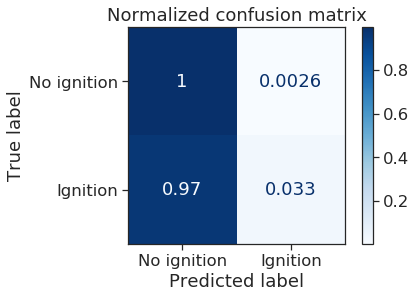

In [8]:
# make training and test data from sampled fire weather data
class_names = np.array(['No ignition', 'Ignition'])
Y = data['ignition']
X = data.drop(['ignition'], axis=1)
x_train_unbalanced, x_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(X.values, Y.values, random_state=rand_seed)

# instantiate and train classifier with defaults
default_xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed
)

start = time()
default_xgb_model.fit(x_train_unbalanced, y_train_unbalanced)
print('XGBClassifier training took {} min.'.format(np.round((time() - start)/60), 2))
    
# score and show confusion matrix
print_model_score(default_xgb_model, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(default_xgb_model, class_names, x_test_unbalanced, y_test_unbalanced)

OK, not good - we missed 97% of fires. Next let's do two things:

1. Stratify the train-test-split so that the training and test sets have the same ratio of ignition to no ignition
2. Try to alleviate the problems caused by imbalanced classes with XGBClassifier's class weight parameter

### Train-test-split stratification and class weighting

In [9]:
x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified = stratified_train_test_split(X, Y, rand_seed)

Class weight: 14.57

XGBClassifier training took 0.0 min.


**Average precision-recall score, training set: 0.4**

**Average precision-recall score, test set: 0.37**

Raw count confusion matrix
[[95651 30472]
 [ 1913  6742]]


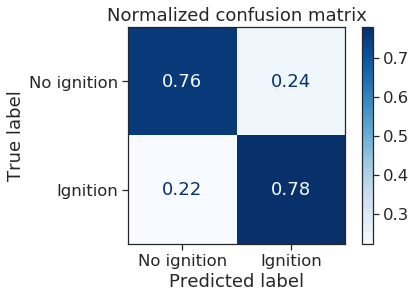

In [10]:
class_weight = no_ignition_count / ignition_count
print('Class weight: {}\n'.format(np.round(class_weight,2)))

# instantiate classifier with class weight
weighted_xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed,
    scale_pos_weight=class_weight
)
# train on stratified data
start = time()
weighted_xgb_model.fit(x_train_stratified, y_train_stratified)
print('XGBClassifier training took {} min.'.format(np.round((time() - start)/60), 2))

# score and show confusion matrix
print_model_score(weighted_xgb_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(weighted_xgb_model, class_names, x_test_stratified, y_test_stratified)

Better! Due to the nature of the problem, the false negative rate is most important but I would also like to see false positives decrease as well.

### Class weight optimization

In [11]:
known_params = {
    'n_jobs': xgb_jobs, 
    'random_state': rand_seed
}

param_dist = {
    'scale_pos_weight': np.arange(0.0, 100, 0.1)
}

optimized_class_weight_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 8 min. for 5 candidate parameter settings.


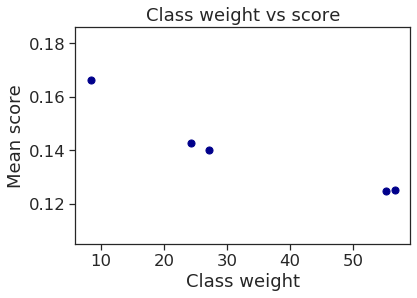

In [12]:
class_weight_optimization_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

plt.scatter(class_weight_optimization_results.param_scale_pos_weight, class_weight_optimization_results.mean_test_score, s=50, color='darkblue')
plt.xlabel("Class weight")
plt.ylabel("Mean score")
plt.title("Class weight vs score")
plt.show()

Optimized class weight: 56.7


**Average precision-recall score, training set: 0.34**

**Average precision-recall score, test set: 0.29**

Raw count confusion matrix
[[106297  19826]
 [  2975   5680]]


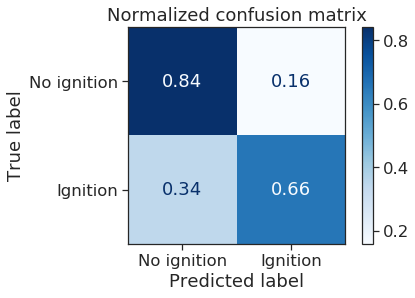

In [13]:
class_weight = class_weight_optimization_results.iloc[0]['param_scale_pos_weight']
print("Optimized class weight: {}".format(np.round(class_weight, 2)))

# score the best model and show confusion matrix
print_model_score(optimized_class_weight_model, x_train_stratified, y_train_stratified, x_test_stratified, y_test_stratified)
display_confusion_matrix(optimized_class_weight_model, class_names, x_test_stratified, y_test_stratified)

### Hyperprameter tuning

**Learning rate and estimator count**

In [14]:
known_params = {
    'random_state': rand_seed,
    'n_jobs': xgb_jobs,
    'scale_pos_weight': class_weight
}

param_dist = {
    'learning_rate': loguniform(0.001, 1),
    'n_estimators': range(1,100)
}

xgb_best_model, xgb_random_search = tune_hyperparameters(
    known_params,
    param_dist, 
    x_train_stratified, 
    y_train_stratified, 
    optimization_jobs, 
    search_iterations, 
    search_scoring_func
)

RandomizedSearchCV took 4 min. for 5 candidate parameter settings.


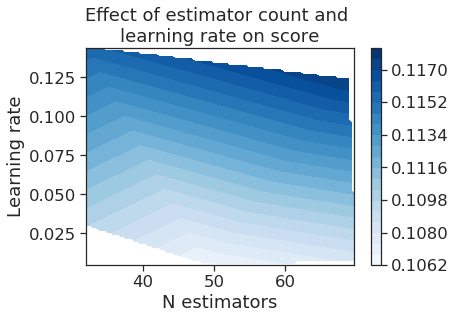

In [15]:
rand_search_results = pd.DataFrame(xgb_random_search.cv_results_).dropna()

x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, 100)

plt.contourf(xi, yi, zi, 20, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

Optimized num estimators: 32
Optimized learning rate: 0.03


**Average precision-recall score, training set: 0.56**

**Average precision-recall score, test set: 0.56**

Raw count confusion matrix
[[55285 49914]
 [  244  6872]]


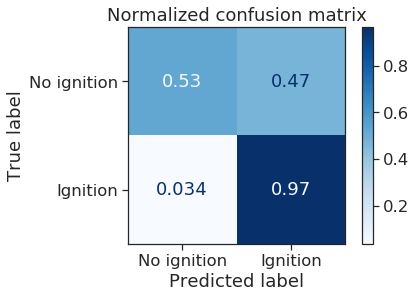

In [16]:
n_estimators = rand_search_results.iloc[0]['param_n_estimators']
print("Optimized num estimators: {}".format(np.round(n_estimators, 2)))

learning_rate = rand_search_results.iloc[0]['param_learning_rate']
print("Optimized learning rate: {}".format(np.round(learning_rate, 2)))

# score and show confusion matrix
print_model_score(xgb_best_model, x_train_unbalanced, y_train_unbalanced, x_test_unbalanced, y_test_unbalanced)
display_confusion_matrix(xgb_best_model, class_names, x_test_unbalanced, y_test_unbalanced)

In [17]:
xgb_model = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed,
    scale_pos_weight=class_weight,
    n_estimators=n_estimators,
    learning_rate=learning_rate
)

xgb_model.fit(x_train_stratified, y_train_stratified)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02983658040822731, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=32, n_jobs=15, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=56.7, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

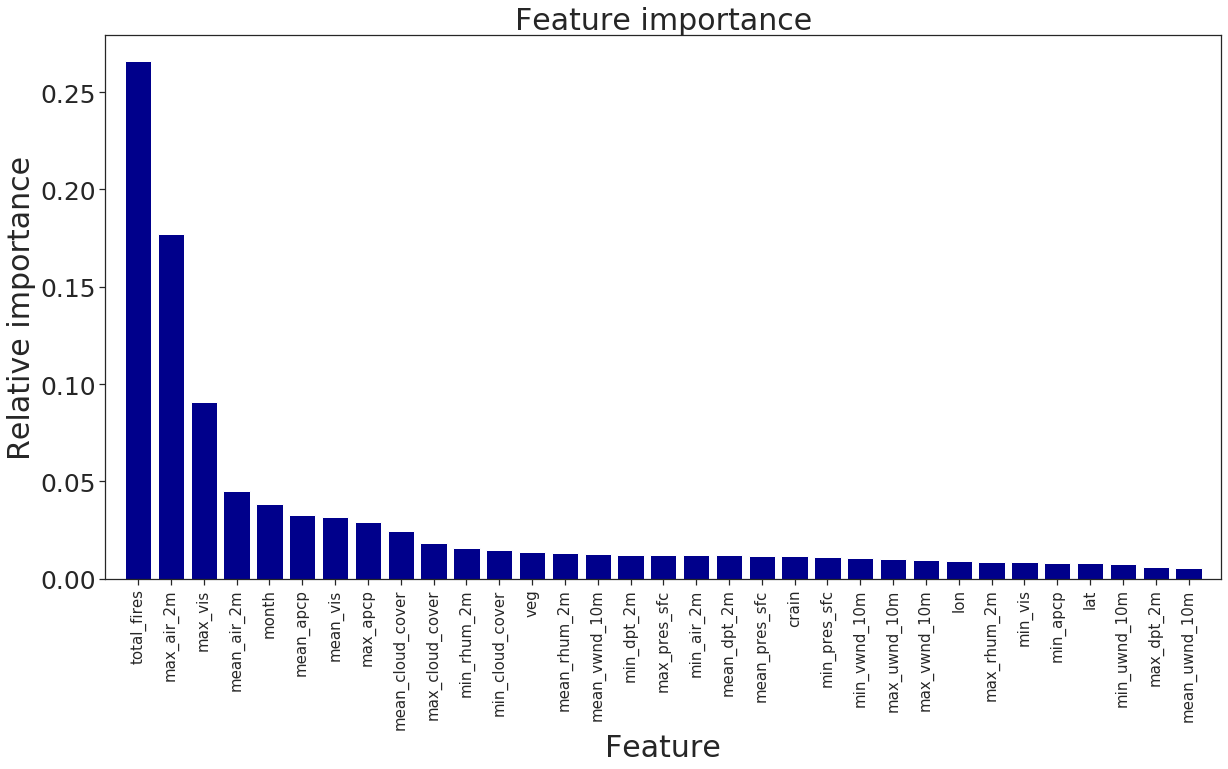

In [18]:
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(list(X))

plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.title("Feature importance")
plt.bar(range(x_test_unbalanced.shape[1]), importances[indices],
       color="darkblue", align="center")
plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, x_test_unbalanced.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

In [19]:
train_scores = list()
test_scores = list()

for n in range(1,(len(feature_names) + 1)):
    # grab top n feature names
    top_n_features = feature_names[indices[0:n]]

    # rebuild training and test sets with feature subset
    data_subset = X[top_n_features]
    x_train_subset, y_train_subset, x_test_subset, y_test_subset = stratified_train_test_split(data_subset, Y, rand_seed)

    # instantiate and train classifier
    xgb_mod = XGBClassifier(
        n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
        random_state=rand_seed,
        scale_pos_weight=class_weight,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

    xgb_mod.fit(x_train_subset, y_train_subset)

    # report score for feature subset
    training_score = average_precision_score(xgb_mod.predict(x_train_subset), y_train_subset)
    test_score = average_precision_score(xgb_mod.predict(x_test_subset), y_test_subset)
    
    train_scores.append(training_score)
    test_scores.append(test_score)
    
    print('Top {} features, precision-recall score train/test: {}/{}'.format(n,np.round(training_score,2),np.round(test_score,2)))

Top 1 features, precision-recall score train/test: 0.74/0.74
Top 2 features, precision-recall score train/test: 0.63/0.63
Top 3 features, precision-recall score train/test: 0.62/0.61
Top 4 features, precision-recall score train/test: 0.61/0.61
Top 5 features, precision-recall score train/test: 0.6/0.6
Top 6 features, precision-recall score train/test: 0.6/0.6
Top 7 features, precision-recall score train/test: 0.6/0.6
Top 8 features, precision-recall score train/test: 0.6/0.6
Top 9 features, precision-recall score train/test: 0.61/0.6
Top 10 features, precision-recall score train/test: 0.61/0.6
Top 11 features, precision-recall score train/test: 0.6/0.6
Top 12 features, precision-recall score train/test: 0.6/0.6
Top 13 features, precision-recall score train/test: 0.6/0.6
Top 14 features, precision-recall score train/test: 0.6/0.6
Top 15 features, precision-recall score train/test: 0.6/0.6
Top 16 features, precision-recall score train/test: 0.6/0.6
Top 17 features, precision-recall score

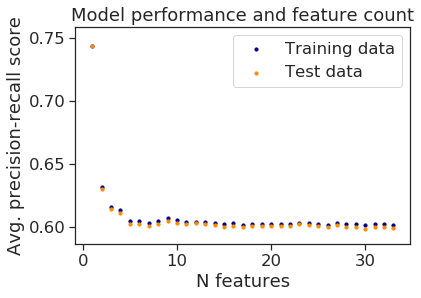

In [20]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(range(1,(len(feature_names) + 1)), train_scores, s=10, c='darkblue', label='Training data')
ax.scatter(range(1,(len(feature_names) + 1)), test_scores, s=10, c='darkorange', label='Test data')
plt.legend(loc='upper right')
plt.title("Model performance and feature count")
plt.xlabel("N features")
plt.ylabel("Avg. precision-recall score")
plt.show()

**Average precision-recall score, training set: 0.61**

**Average precision-recall score, test set: 0.61**

Raw count confusion matrix
[[57646 68477]
 [  384  8271]]


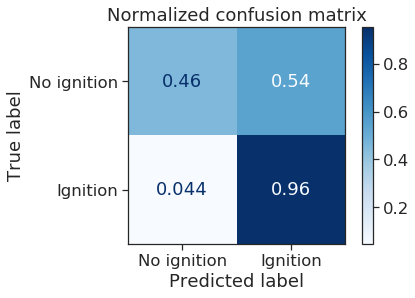

In [21]:
# grab top n feature names
top_n_features = feature_names[indices[0:4]]

# rebuild training and test sets with feature subset
data_subset = X[top_n_features]
x_train_subset, y_train_subset, x_test_subset, y_test_subset = stratified_train_test_split(data_subset, Y, rand_seed)

# instantiate and train classifier with optimized hyperparameters
xgb_mod = XGBClassifier(
    n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
    random_state=rand_seed,
    scale_pos_weight=class_weight,
    n_estimators=n_estimators,
    learning_rate=learning_rate
)

xgb_mod.fit(x_train_subset, y_train_subset)

# score and show confusion matrix
print_model_score(xgb_mod, x_train_subset, y_train_subset, x_test_subset, y_test_subset)
display_confusion_matrix(xgb_mod, class_names, x_test_subset, y_test_subset)

In [22]:
top_n_features

array(['total_fires', 'max_air_2m', 'max_vis', 'mean_air_2m'],
      dtype='<U16')

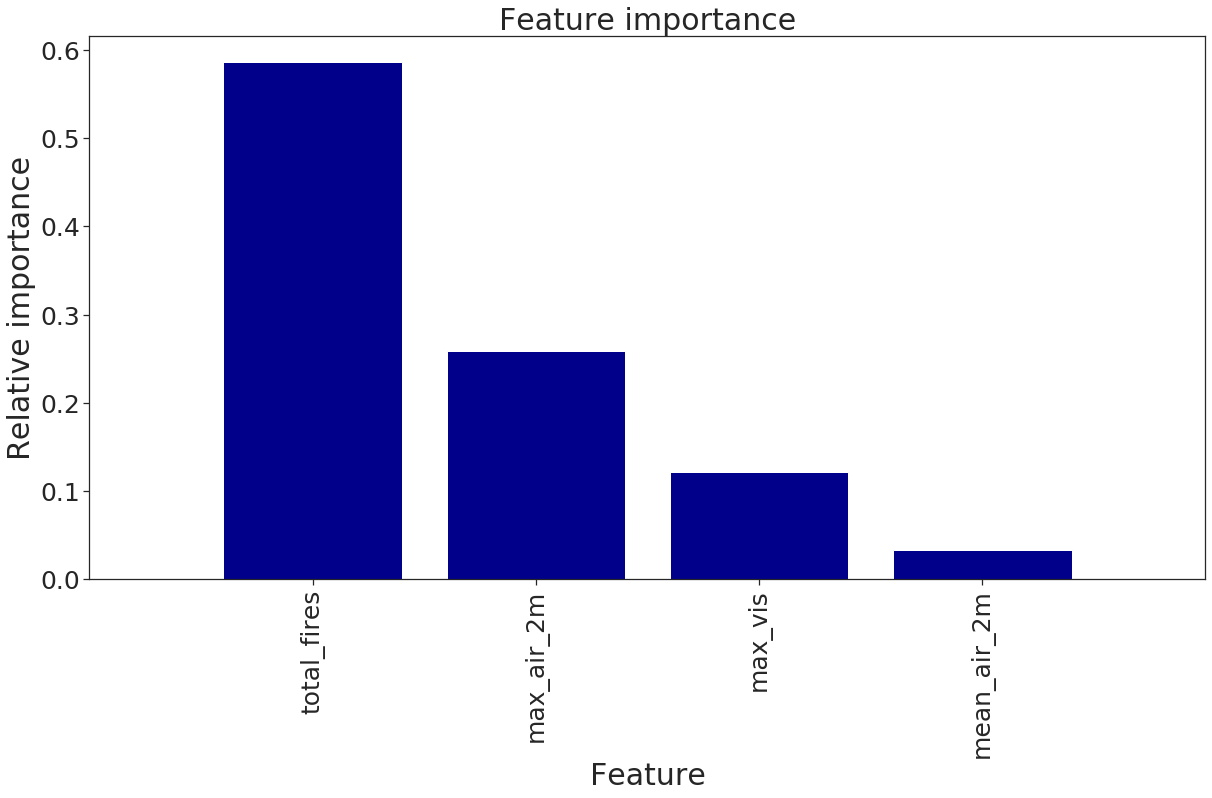

In [23]:
importances = xgb_mod.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = top_n_features

plt.figure(figsize=(20,10))
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.title("Feature importance")
plt.bar(range(x_test_subset.shape[1]), importances[indices],
       color="darkblue", align="center")
plt.xticks(np.arange(len(indices)), feature_names[indices], rotation='vertical')
plt.xlim([-1, x_test_subset.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Relative importance")
plt.show()

In [24]:
from random import randint

train_scores = list()
test_scores = list()
false_neg_rates = list()
false_pos_rates = list()

# grab top n feature names
top_n_features = feature_names[indices[0:6]]
data_subset = X[top_n_features]

for i in range(0, 10):

    # rebuild training and test sets with feature subset
    # note: we are passing a different pesudorandom seed each
    # time so we should end up with different samples
    x_train_subset, y_train_subset, x_test_subset, y_test_subset = stratified_train_test_split(data_subset, Y, randint(0, 1e5))

    # instantiate and train classifier with optimized hyperparameters
    xgb_mod = XGBClassifier(
        n_jobs=(xgb_jobs * optimization_jobs), # use everything we've got! 
        random_state=rand_seed,
        scale_pos_weight=class_weight,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

    xgb_mod.fit(x_train_subset, y_train_subset)
    predicted_y = xgb_mod.predict(x_test_subset)
    
    training_score = average_precision_score(xgb_mod.predict(x_train_subset), y_train_subset)
    test_score = average_precision_score(predicted_y, y_test_subset)

    train_scores.append(training_score)
    test_scores.append(test_score)
    
    cm = confusion_matrix(y_test_subset, predicted_y)
    
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    false_neg_rates.append(FN / (FN + TN))
    false_pos_rates.append(FP / (FP + TN))

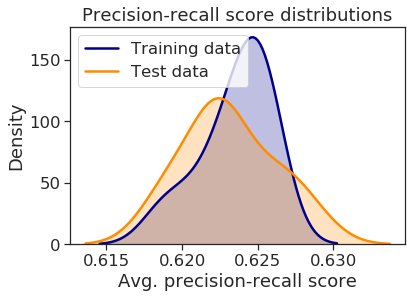

In [25]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax = sns.kdeplot(train_scores, label="Training data", shade=True, color="darkblue")
ax = sns.kdeplot(test_scores, label="Test data", shade=True, color="darkorange")
ax.set_title("Precision-recall score distributions")
ax.set(xlabel='Avg. precision-recall score', ylabel='Density')
plt.legend()

plt.show()

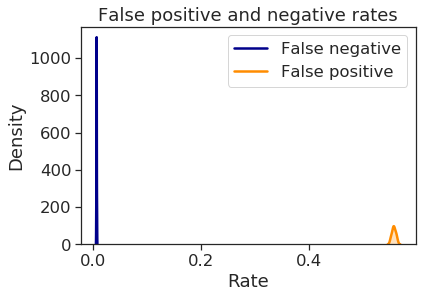

In [26]:
ax = sns.kdeplot(false_neg_rates, label="False negative", shade=True, color="darkblue")
ax = sns.kdeplot(false_pos_rates, label="False positive", shade=True, color="darkorange")
ax.set_title("False positive and negative rates")
ax.set(xlabel='Rate', ylabel='Density')
plt.legend()

plt.show()

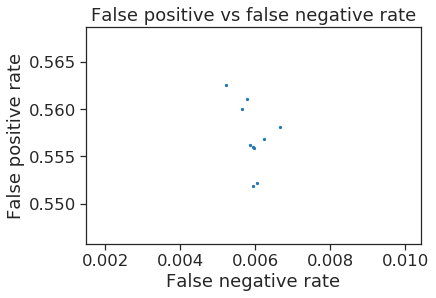

In [27]:
plt.scatter(false_neg_rates, false_pos_rates, s=5)
plt.xlabel("False negative rate")
plt.ylabel("False positive rate")
plt.title("False positive vs false negative rate")

plt.show()